In [17]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings(action='ignore')

import tensorflow as tf
tf.get_logger().setLevel('ERROR')
gpu_devices = tf.config.experimental.list_physical_devices("GPU")
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

# Make Input

In [281]:
def txtToDataframe(filename, flag1, flag2):
    file = open(filename, 'r')
    lines = file.readlines()
    datas = []
    for line in lines:
        txt = line.replace('   ', ' ').lstrip().rstrip().replace(' ', ',')
        data = txt.split(',')
        datas.append(data)
    df = pd.DataFrame(datas)
    df.columns = ['AF3', 'F7', 'F3', 'FC5', 'T7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'F8', 'AF4']
    df['label1']=flag1
    df['label2']=flag2
    return df


def getData(src) :
    file_list = os.listdir(src)
    
    rating = pd.DataFrame(pd.read_csv(src+'ratings.txt'))
    file_list.remove('ratings.txt')
    
    dataList=[]
    highList=[]
    lowList=[]
    
    print(rating.columns)
    j=0
    for i in rating['subject']:
        if i<10:
            num = str(0)+str(i)
        else:
            num = str(i)
        dataList.append(txtToDataframe(src+'sub'+num+'_hi.txt', 1,rating['test'][j]))
        dataList.append(txtToDataframe(src+'sub'+num+'_lo.txt', 0,rating['rest'][j]))
        highList.append(txtToDataframe(src+'sub'+num+'_hi.txt', 1,rating['test'][j]))
        lowList.append(txtToDataframe(src+'sub'+num+'_lo.txt', 0,rating['rest'][j]))
        j+=1
    return dataList, highList, lowList

src = 'data/STEW Dataset/'
originalData, highData, lowData = getData(src)

Index(['subject', 'rest', 'test'], dtype='object')


In [301]:
def mergedData(dataList):
    merged_data = pd.concat([dataList[0],dataList[1]],ignore_index=True)
    for i in range(2,len(dataList)):
        merged_data = pd.concat([merged_data,dataList[i]],ignore_index=True)
    merged_data = merged_data.apply(pd.to_numeric)
    return merged_data

In [292]:
mergedData = mergedData(originalData)
label=mergedData['label1']
data=mergedData.drop(['label1','label2'],axis=1)

In [284]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled = scaler.fit_transform(data)
data = pd.DataFrame(scaled, columns = data.columns, index=data.index)
data

,AF3,F7,F3,FC5,T7,O1,O2,P8,T8,FC6,F4,F8,F8,AF4
0,0.558932,0.452258,0.539627,0.553295,0.479273,0.449631,0.482450,0.542340,0.558323,0.505813,0.479338,0.521798,0.533296,0.494656
1,0.558867,0.451482,0.540022,0.550698,0.479207,0.449895,0.483076,0.543015,0.558871,0.506793,0.480193,0.521187,0.535799,0.490618
2,0.557644,0.451223,0.540286,0.551317,0.479142,0.450158,0.483952,0.543629,0.559726,0.508383,0.479766,0.519600,0.538119,0.488070
3,0.557580,0.452775,0.539759,0.556078,0.480956,0.450357,0.484202,0.544427,0.560153,0.508873,0.480681,0.520759,0.537874,0.491798
4,0.558803,0.453422,0.539430,0.557129,0.482576,0.450753,0.484076,0.544489,0.560032,0.508444,0.482268,0.522042,0.538057,0.493351
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1727995,0.506663,0.480335,0.481982,0.504143,0.541975,0.478809,0.499843,0.512926,0.527864,0.479439,0.542453,0.561057,0.560825,0.551323
1727996,0.506404,0.480140,0.482113,0.504018,0.542493,0.479074,0.499781,0.512004,0.527193,0.479073,0.542391,0.561301,0.560215,0.550765
1727997,0.506598,0.479816,0.481850,0.503833,0.542104,0.478809,0.499155,0.510224,0.526094,0.477727,0.541964,0.560813,0.559361,0.550143
1727998,0.506920,0.479752,0.481785,0.504081,0.541456,0.478677,0.498968,0.510347,0.526277,0.477665,0.542026,0.560752,0.559788,0.550765


In [308]:
high_data = mergedData(highData)
high_label = high_data['label2']
high_data = high_data.drop(['label1','label2'],axis=1)
high_scaled = scaler.fit_transform(high_data)
high_data = pd.DataFrame(high_scaled, columns = high_data.columns, index=high_data.index)

In [330]:
low_data = mergedData(lowData)
low_label = low_data['label2']
low_data = low_data.drop(['label1','label2'],axis=1)
low_scaled = scaler.fit_transform(low_data)
low_data = pd.DataFrame(low_scaled, columns = low_data.columns, index=low_data.index)

In [331]:
def windowing_dataset(data, label, window_size):
    data_list = []
    label_list = []
    
    for i in range(0,len(data)//window_size,window_size):
        data_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i]))
    return np.array(data_list), np.array(label_list)

dataList, labelList = windowing_dataset(data,label,14)
print(data.shape, label.shape, dataList.shape, labelList.shape)

(1728000, 14) (1728000,) (8817, 14, 14) (8817,)


In [418]:
from tensorflow.keras.utils import to_categorical

high_dataList, high_labelList = windowing_dataset(high_data,high_label,14)
high_labelList = to_categorical(high_labelList,9)
print(high_data.shape, high_label.shape, high_dataList.shape, high_labelList.shape)

(864000, 14) (864000,) (4409, 14, 14) (4409, 9)


In [419]:
low_dataList, low_labelList = windowing_dataset(low_data,low_label,14)
low_labelList = to_categorical(low_labelList,9)
print(low_data.shape, low_label.shape, low_dataList.shape, low_labelList.shape)

(864000, 14) (864000,) (4409, 14, 14) (4409, 9)


In [422]:
high_labelList=high_labelList.astype('int32')
low_labelList=low_labelList.astype('int32')

high_labelList.dtype, low_labelList.dtype

(dtype('int32'), dtype('int32'))

# Model Tuning

## Model 1

In [366]:
from autokeras.keras_layers import ExpandLastDim
from autokeras.keras_layers import CastToFloat32
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, GlobalAveragePooling2D, LSTM, SimpleRNN
from tensorflow.keras.layers import InputLayer, Dense, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [367]:
from tensorflow.keras.layers.experimental.preprocessing import RandomTranslation, RandomFlip
from tensorflow.keras.layers.experimental.preprocessing import Resizing
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.applications import EfficientNetB7

In [254]:
import matplotlib.pyplot as plt

def drawResult(history):
    fig, loss_ax = plt.subplots()
    acc_ax = loss_ax.twinx()

    loss_ax.plot(history.history['loss'], 'y', label='train loss')
    loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    loss_ax.legend(loc='upper left')

    acc_ax.plot(history.history['accuracy'], 'b', label='train acc')
    acc_ax.plot(history.history['val_accuracy'], 'g', label='val acc')
    acc_ax.set_ylabel('accuracy')
    acc_ax.legend(loc='upper left')

    plt.show()

In [444]:
from sklearn.metrics import f1_score

def runModel(model, crossentropy, x_train, y_train, x_valid, y_valid):
    early_stop = EarlyStopping(monitor='val_loss', patience=10)
    model.compile(optimizer='adam', loss= crossentropy, metrics='accuracy')

    history = model.fit(x_train, y_train, 
                        epochs = 200, 
                        validation_data = (x_valid, y_valid), 
                        callbacks=[early_stop], verbose=0)
    drawResult(history)
    return model
    
def eval_model(model, x_test, y_test):
    pred = model.predict(x_test)
    y_pred = pred.round(0).astype('int32')

    return f1_score(y_test, y_pred, average='macro')

In [427]:
def Model1_1():
    model = Sequential()
    model.add(InputLayer(input_shape=(14, 14)))
    model.add(ExpandLastDim())
    model.add(CastToFloat32())
    
    model.add(Conv2D(512, kernel_size=(2,2), strides=(1,1), activation='relu', padding='valid'))
    model.add(Conv2D(512, kernel_size=(2,2), strides=(1,1), activation='relu', padding='valid'))
    model.add(MaxPooling2D(2,2))
    
    model.add(Conv2D(128, kernel_size=(2,2), strides=(1,1), activation='relu', padding='same'))
    model.add(Conv2D(128, kernel_size=(2,2), strides=(1,1), activation='relu', padding='same'))
    model.add(MaxPooling2D(2,2))
    
    model.add(Conv2D(32, kernel_size=(2,2), strides=(1,1), activation='relu', padding='same'))
    model.add(Conv2D(32, kernel_size=(2,2), strides=(1,1), activation='relu', padding='same'))
    
    model.add(Flatten())
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    #model.summary()
    return model

def Model1_2():
    model = Sequential()
    model.add(InputLayer(input_shape=(14, 14)))
    model.add(ExpandLastDim())
    model.add(CastToFloat32())
    
    model.add(Conv2D(512, kernel_size=(2,2), strides=(1,1), activation='relu', padding='valid'))
    model.add(Conv2D(512, kernel_size=(2,2), strides=(1,1), activation='relu', padding='valid'))
    model.add(MaxPooling2D(2,2))
    
    model.add(Conv2D(128, kernel_size=(2,2), strides=(1,1), activation='relu', padding='same'))
    model.add(Conv2D(128, kernel_size=(2,2), strides=(1,1), activation='relu', padding='same'))
    model.add(MaxPooling2D(2,2))
    
    model.add(Conv2D(32, kernel_size=(2,2), strides=(1,1), activation='relu', padding='same'))
    model.add(Conv2D(32, kernel_size=(2,2), strides=(1,1), activation='relu', padding='same'))
    
    model.add(Flatten())
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    #model.summary()
    return model

def Model1_3():
    model = Sequential()
    model.add(InputLayer(input_shape=(14, 14)))
    model.add(ExpandLastDim())
    model.add(CastToFloat32())
    
    model.add(Conv2D(512, kernel_size=(2,2), strides=(1,1), activation='relu', padding='valid'))
    model.add(Conv2D(512, kernel_size=(2,2), strides=(1,1), activation='relu', padding='valid'))
    model.add(MaxPooling2D(2,2))
    
    model.add(Conv2D(128, kernel_size=(2,2), strides=(1,1), activation='relu', padding='same'))
    model.add(Conv2D(128, kernel_size=(2,2), strides=(1,1), activation='relu', padding='same'))
    model.add(MaxPooling2D(2,2))
    
    model.add(Conv2D(32, kernel_size=(2,2), strides=(1,1), activation='relu', padding='same'))
    model.add(Conv2D(32, kernel_size=(2,2), strides=(1,1), activation='relu', padding='same'))
    
    model.add(GlobalMaxPooling2D())
    model.add(Dense(1, activation='sigmoid'))
    
    #model.summary()
    return model

In [428]:
X_train, X_, Y_train, Y_ = train_test_split(dataList,labelList, train_size=0.7, random_state=True ,stratify = labelList)
X_valid, X_test, Y_valid, Y_test = train_test_split(X_,Y_, train_size=0.5, random_state=True ,stratify = Y_)

print(X_train.shape, X_valid.shape, X_test.shape, Y_train.shape, Y_valid.shape, Y_test.shape)
print(X_train.dtype, X_valid.dtype, X_test.dtype, Y_train.dtype, Y_valid.dtype, Y_test.dtype)

(6171, 14, 14) (1323, 14, 14) (1323, 14, 14) (6171,) (1323,) (1323,)
float64 float64 float64 int64 int64 int64


Epoch 1/200
193/193 [==============================] - 3s 13ms/step - loss: 4.4092 - accuracy: 0.6108 - val_loss: 0.5245 - val_accuracy: 0.7377
Epoch 2/200
193/193 [==============================] - 2s 12ms/step - loss: 0.5387 - accuracy: 0.6997 - val_loss: 0.4997 - val_accuracy: 0.7642
Epoch 3/200
193/193 [==============================] - 2s 12ms/step - loss: 0.4649 - accuracy: 0.7561 - val_loss: 0.4646 - val_accuracy: 0.7566
Epoch 4/200
193/193 [==============================] - 2s 13ms/step - loss: 0.4458 - accuracy: 0.7728 - val_loss: 0.4110 - val_accuracy: 0.8420
Epoch 5/200
193/193 [==============================] - 2s 12ms/step - loss: 0.3894 - accuracy: 0.8206 - val_loss: 0.4610 - val_accuracy: 0.7543
Epoch 6/200
193/193 [==============================] - 2s 12ms/step - loss: 0.4313 - accuracy: 0.7932 - val_loss: 0.4658 - val_accuracy: 0.7491
Epoch 7/200
193/193 [==============================] - 2s 13ms/step - loss: 0.3759 - accuracy: 0.8200 - val_loss: 0.4411 - val_accuracy:

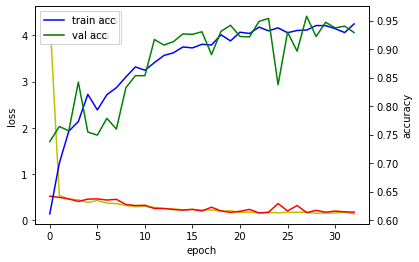

0.9332464875625541


In [429]:
crossentropy = 'binary_crossentropy'

print(eval_model(runModel(Model1_1(),crossentropy,X_train, Y_train, X_valid, Y_valid), X_test, Y_test))

Epoch 1/200
193/193 [==============================] - 3s 14ms/step - loss: 5.3811 - accuracy: 0.6043 - val_loss: 0.6484 - val_accuracy: 0.6599
Epoch 2/200
193/193 [==============================] - 3s 13ms/step - loss: 0.5087 - accuracy: 0.7224 - val_loss: 0.4560 - val_accuracy: 0.7611
Epoch 3/200
193/193 [==============================] - 3s 13ms/step - loss: 0.4684 - accuracy: 0.7444 - val_loss: 0.4640 - val_accuracy: 0.7778
Epoch 4/200
193/193 [==============================] - 3s 13ms/step - loss: 0.4086 - accuracy: 0.7932 - val_loss: 0.4050 - val_accuracy: 0.8231
Epoch 5/200
193/193 [==============================] - 3s 13ms/step - loss: 0.4126 - accuracy: 0.7978 - val_loss: 0.4009 - val_accuracy: 0.8125
Epoch 6/200
193/193 [==============================] - 3s 13ms/step - loss: 0.3769 - accuracy: 0.8211 - val_loss: 0.3843 - val_accuracy: 0.8246
Epoch 7/200
193/193 [==============================] - 3s 13ms/step - loss: 0.3776 - accuracy: 0.8141 - val_loss: 0.4017 - val_accuracy:

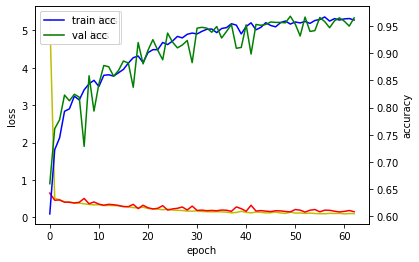

0.962714496467117


In [430]:
print(eval_model(runModel(Model1_2(),crossentropy,X_train, Y_train, X_valid, Y_valid), X_test, Y_test))

Epoch 1/200
193/193 [==============================] - 3s 13ms/step - loss: 7.3334 - accuracy: 0.5814 - val_loss: 0.5403 - val_accuracy: 0.6901
Epoch 2/200
193/193 [==============================] - 2s 12ms/step - loss: 0.5981 - accuracy: 0.6655 - val_loss: 0.5692 - val_accuracy: 0.6266
Epoch 3/200
193/193 [==============================] - 2s 12ms/step - loss: 0.4813 - accuracy: 0.7454 - val_loss: 0.4435 - val_accuracy: 0.7566
Epoch 4/200
193/193 [==============================] - 2s 12ms/step - loss: 0.4318 - accuracy: 0.7772 - val_loss: 0.4393 - val_accuracy: 0.7891
Epoch 5/200
193/193 [==============================] - 2s 12ms/step - loss: 0.3905 - accuracy: 0.8185 - val_loss: 0.3984 - val_accuracy: 0.7763
Epoch 6/200
193/193 [==============================] - 2s 12ms/step - loss: 0.3807 - accuracy: 0.8217 - val_loss: 0.3294 - val_accuracy: 0.8972
Epoch 7/200
193/193 [==============================] - 2s 12ms/step - loss: 0.3260 - accuracy: 0.8532 - val_loss: 0.3119 - val_accuracy:

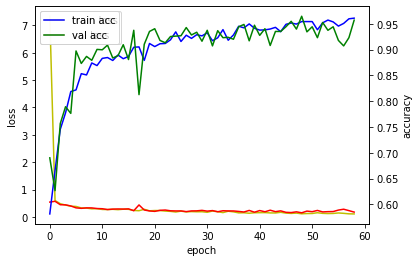

0.9643570587995893


In [431]:
print(eval_model(runModel(Model1_3(),crossentropy,X_train, Y_train, X_valid, Y_valid), X_test, Y_test))

In [462]:
def Model2_1_1():
    model = Sequential()
    model.add(InputLayer(input_shape=(14, 14)))
    model.add(ExpandLastDim())
    model.add(CastToFloat32())
    
    model.add(Conv2D(512, kernel_size=(4,4), strides=(1,1), activation='relu', padding='valid'))
    model.add(Conv2D(512, kernel_size=(4,4), strides=(1,1), activation='relu', padding='valid'))
    model.add(MaxPooling2D(2,2))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dropout(0.25))
    
    model.add(Dense(9, activation='sigmoid'))
    
    #model.summary()
    return model

def Model2_1_2():
    model = Sequential()
    model.add(InputLayer(input_shape=(14, 14)))
    model.add(ExpandLastDim())
    model.add(CastToFloat32())
    
    model.add(Conv2D(512, kernel_size=(2,2), strides=(1,1), activation='relu', padding='valid'))
    model.add(Conv2D(512, kernel_size=(2,2), strides=(1,1), activation='relu', padding='valid'))
    model.add(MaxPooling2D(2,2))
    
    model.add(Conv2D(128, kernel_size=(2,2), strides=(1,1), activation='relu', padding='same'))
    model.add(Conv2D(128, kernel_size=(2,2), strides=(1,1), activation='relu', padding='same'))
    model.add(MaxPooling2D(2,2))
    
    model.add(Conv2D(32, kernel_size=(2,2), strides=(1,1), activation='relu', padding='same'))
    model.add(Conv2D(32, kernel_size=(2,2), strides=(1,1), activation='relu', padding='same'))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dropout(0.25))
    
    model.add(Dense(50, activation='relu'))
    model.add(Dense(9, activation='sigmoid'))
    
    #model.summary()
    return model

def Model2_1_3():
    model = Sequential()
    model.add(InputLayer(input_shape=(14, 14)))
    model.add(ExpandLastDim())
    model.add(CastToFloat32())
    
    model.add(Conv2D(512, kernel_size=(4,4), strides=(1,1), activation='relu', padding='valid'))
    model.add(Conv2D(512, kernel_size=(4,4), strides=(1,1), activation='relu', padding='valid'))
    model.add(MaxPooling2D(2,2))
    
    model.add(Conv2D(128, kernel_size=(4,4), strides=(1,1), activation='relu', padding='same'))
    model.add(Conv2D(128, kernel_size=(4,4), strides=(1,1), activation='relu', padding='same'))
    model.add(MaxPooling2D(2,2))
    
    model.add(Conv2D(32, kernel_size=(4,4), strides=(1,1), activation='relu', padding='same'))
    model.add(Conv2D(32, kernel_size=(4,4), strides=(1,1), activation='relu', padding='same'))
    
    model.add(Flatten())
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(9, activation='sigmoid'))
    
    #model.summary()
    return model

In [463]:
high_x_train, high_x_, high_y_train, high_y_ = train_test_split(high_dataList,high_labelList, train_size=0.7, random_state=True ,stratify = high_labelList)
high_x_valid, high_x_test, high_y_valid, high_y_test = train_test_split(high_x_,high_y_, train_size=0.5, random_state=True ,stratify = high_y_)

print(high_x_train.shape, high_x_valid.shape, high_x_test.shape, high_y_train.shape, high_y_valid.shape, high_y_test.shape)
print(high_x_train.dtype, high_x_valid.dtype, high_x_test.dtype, high_y_train.dtype, high_y_valid.dtype, high_y_test.dtype)

(3086, 14, 14) (661, 14, 14) (662, 14, 14) (3086, 9) (661, 9) (662, 9)
float64 float64 float64 int32 int32 int32


In [464]:
def eval_model2(model, x_test, y_test):
    y_pred = model.predict(x_test)
    return f1_score(y_test.argmax(axis=1), y_pred.argmax(axis=1), average='macro')

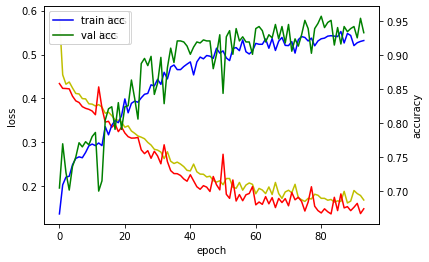

0.9339760638297872


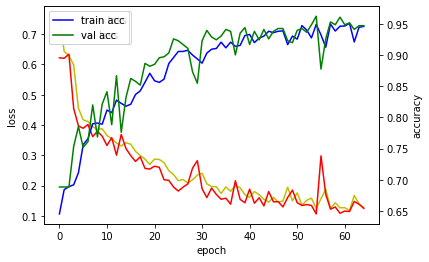

0.9531630964820621


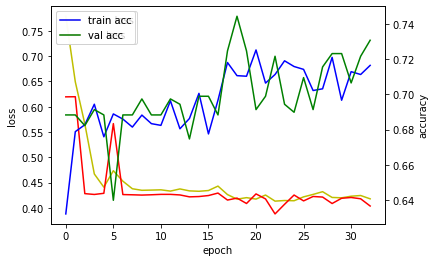

0.7260915493771657


In [466]:
crossentropy = 'categorical_crossentropy'

print(eval_model2(runModel(Model2_1_1(),crossentropy,high_x_train, high_y_train, high_x_valid, high_y_valid), high_x_test, high_y_test))
print(eval_model2(runModel(Model2_1_2(),crossentropy,high_x_train, high_y_train, high_x_valid, high_y_valid), high_x_test, high_y_test))
print(eval_model2(runModel(Model2_1_3(),crossentropy,high_x_train, high_y_train, high_x_valid, high_y_valid), high_x_test, high_y_test))

In [457]:
def Model2_2_1():
    model = Sequential()
    model.add(InputLayer(input_shape=(14, 14)))
    model.add(ExpandLastDim())
    model.add(CastToFloat32())
    
    model.add(Conv2D(512, kernel_size=(4,4), strides=(1,1), activation='relu', padding='valid'))
    model.add(Conv2D(512, kernel_size=(4,4), strides=(1,1), activation='relu', padding='valid'))
    model.add(MaxPooling2D(2,2))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dropout(0.25))
    
    model.add(Dense(9, activation='sigmoid'))
    
    #model.summary()
    return model

def Model2_2_2():
    model = Sequential()
    model.add(InputLayer(input_shape=(14, 14)))
    model.add(ExpandLastDim())
    model.add(CastToFloat32())
    
    model.add(Conv2D(512, kernel_size=(2,2), strides=(1,1), activation='relu', padding='valid'))
    model.add(Conv2D(512, kernel_size=(2,2), strides=(1,1), activation='relu', padding='valid'))
    model.add(MaxPooling2D(2,2))
    
    model.add(Conv2D(128, kernel_size=(2,2), strides=(1,1), activation='relu', padding='same'))
    model.add(Conv2D(128, kernel_size=(2,2), strides=(1,1), activation='relu', padding='same'))
    model.add(MaxPooling2D(2,2))
    
    model.add(Conv2D(32, kernel_size=(2,2), strides=(1,1), activation='relu', padding='same'))
    model.add(Conv2D(32, kernel_size=(2,2), strides=(1,1), activation='relu', padding='same'))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dropout(0.25))
    
    model.add(Dense(50, activation='relu'))
    model.add(Dense(9, activation='sigmoid'))
    
    model.summary()
    return model

def Model2_2_3():
    model = Sequential()
    model.add(InputLayer(input_shape=(14, 14)))
    model.add(ExpandLastDim())
    model.add(CastToFloat32())
    
    model.add(Conv2D(512, kernel_size=(4,4), strides=(1,1), activation='relu', padding='valid'))
    model.add(Conv2D(512, kernel_size=(4,4), strides=(1,1), activation='relu', padding='valid'))
    model.add(MaxPooling2D(2,2))
    
    model.add(Conv2D(128, kernel_size=(4,4), strides=(1,1), activation='relu', padding='same'))
    model.add(Conv2D(128, kernel_size=(4,4), strides=(1,1), activation='relu', padding='same'))
    model.add(MaxPooling2D(2,2))
    
    model.add(Conv2D(32, kernel_size=(4,4), strides=(1,1), activation='relu', padding='same'))
    model.add(Conv2D(32, kernel_size=(4,4), strides=(1,1), activation='relu', padding='same'))
    
    model.add(Flatten())
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(9, activation='sigmoid'))
    
    #model.summary()
    return model

In [460]:
low_x_train, low_x_, low_y_train, low_y_ = train_test_split(low_dataList,low_labelList, train_size=0.7, random_state=True ,stratify = low_labelList)
low_x_valid, low_x_test, low_y_valid, low_y_test = train_test_split(low_x_,low_y_, train_size=0.5, random_state=True ,stratify = low_y_)

print(low_x_train.shape, low_x_valid.shape, low_x_test.shape, low_y_train.shape, low_y_valid.shape, low_y_test.shape)
print(low_x_train.dtype, low_x_valid.dtype, low_x_test.dtype, low_y_train.dtype, low_y_valid.dtype, low_y_test.dtype)

(3086, 14, 14) (661, 14, 14) (662, 14, 14) (3086, 9) (661, 9) (662, 9)
float64 float64 float64 int32 int32 int32


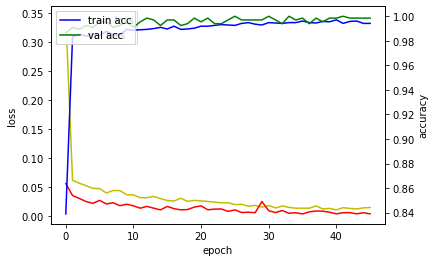

0.9967813141184593


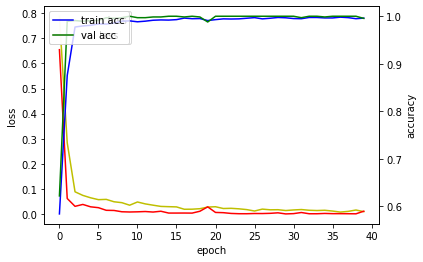

0.9967813141184593


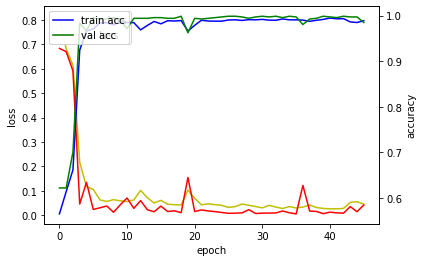

0.9838007145304164


In [461]:
crossentropy = 'categorical_crossentropy'

print(eval_model2(runModel(Model2_2_1(),crossentropy,low_x_train, low_y_train, low_x_valid, low_y_valid), low_x_test, low_y_test))
print(eval_model2(runModel(Model2_2_2(),crossentropy,low_x_train, low_y_train, low_x_valid, low_y_valid), low_x_test, low_y_test))
print(eval_model2(runModel(Model2_2_3(),crossentropy,low_x_train, low_y_train, low_x_valid, low_y_valid), low_x_test, low_y_test))

In [467]:
model = Sequential()
model.add(InputLayer(input_shape=(14, 14)))
model.add(ExpandLastDim())
model.add(CastToFloat32())
    
model.add(Conv2D(512, kernel_size=(2,2), strides=(1,1), activation='relu', padding='valid'))
model.add(Conv2D(512, kernel_size=(2,2), strides=(1,1), activation='relu', padding='valid'))
model.add(MaxPooling2D(2,2))
    
model.add(Conv2D(128, kernel_size=(2,2), strides=(1,1), activation='relu', padding='same'))
model.add(Conv2D(128, kernel_size=(2,2), strides=(1,1), activation='relu', padding='same'))
model.add(MaxPooling2D(2,2))
    
model.add(Conv2D(32, kernel_size=(2,2), strides=(1,1), activation='relu', padding='same'))
model.add(Conv2D(32, kernel_size=(2,2), strides=(1,1), activation='relu', padding='same'))
model.add(Dropout(0.25))
    
model.add(Flatten())
model.add(Dropout(0.25))
    
model.add(Dense(50, activation='relu'))
model.add(Dense(9, activation='sigmoid'))
    
model.summary()

Model: "sequential_167"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
expand_last_dim_129 (ExpandL (None, 14, 14, 1)         0         
_________________________________________________________________
cast_to_float32_143 (CastToF (None, 14, 14, 1)         0         
_________________________________________________________________
conv2d_659 (Conv2D)          (None, 13, 13, 512)       2560      
_________________________________________________________________
conv2d_660 (Conv2D)          (None, 12, 12, 512)       1049088   
_________________________________________________________________
max_pooling2d_259 (MaxPoolin (None, 6, 6, 512)         0         
_________________________________________________________________
conv2d_661 (Conv2D)          (None, 6, 6, 128)         262272    
_________________________________________________________________
conv2d_662 (Conv2D)          (None, 6, 6, 128)      

In [468]:
    model = Sequential()
    model.add(InputLayer(input_shape=(14, 14)))
    model.add(ExpandLastDim())
    model.add(CastToFloat32())
    
    model.add(Conv2D(512, kernel_size=(2,2), strides=(1,1), activation='relu', padding='valid'))
    model.add(Conv2D(512, kernel_size=(2,2), strides=(1,1), activation='relu', padding='valid'))
    model.add(MaxPooling2D(2,2))
    
    model.add(Conv2D(128, kernel_size=(2,2), strides=(1,1), activation='relu', padding='same'))
    model.add(Conv2D(128, kernel_size=(2,2), strides=(1,1), activation='relu', padding='same'))
    model.add(MaxPooling2D(2,2))
    
    model.add(Conv2D(32, kernel_size=(2,2), strides=(1,1), activation='relu', padding='same'))
    model.add(Conv2D(32, kernel_size=(2,2), strides=(1,1), activation='relu', padding='same'))
    
    model.add(GlobalMaxPooling2D())
    model.add(Dense(1, activation='sigmoid'))
    
    model.summary()

Model: "sequential_168"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
expand_last_dim_130 (ExpandL (None, 14, 14, 1)         0         
_________________________________________________________________
cast_to_float32_144 (CastToF (None, 14, 14, 1)         0         
_________________________________________________________________
conv2d_665 (Conv2D)          (None, 13, 13, 512)       2560      
_________________________________________________________________
conv2d_666 (Conv2D)          (None, 12, 12, 512)       1049088   
_________________________________________________________________
max_pooling2d_261 (MaxPoolin (None, 6, 6, 512)         0         
_________________________________________________________________
conv2d_667 (Conv2D)          (None, 6, 6, 128)         262272    
_________________________________________________________________
conv2d_668 (Conv2D)          (None, 6, 6, 128)      